# Multiple detector planes

This is a simple test of running a simulation with multiple detector planes, and loading the data from them

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ROOT
import os

Welcome to JupyROOT 6.20/04


In [2]:
#Setup MiniScatter -- modify the path to where you built MiniScatter!
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

In [3]:
#Enable zooming etc. on MATPLOTLIB plots inside JuPyter (not in JupyterLab!)

# %matplotlib notebook

#If necessary, set different figsizes and get the color cycle
#
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
# 
# colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [4]:
#Disable putting scroll bars on the output if it is long
#
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

## Simulation setup

In [5]:
### Basic simulation parameters ###

QUIET   = False #Reduced output?
TRYLOAD = True  #Try to load already existing data instead of recomputing?
NUM_THREADS = 4 #Number of parallel threads to use for scans
#Where to store temporary data for scans (a fast file system, NOT EOS/AFS)
TMPFOLDER = "/tmp/miniScatter/MultipleDetectorPlanes"

baseSimSetup = {}
#baseSimSetup["PHYS"]  = "QGSP_BERT"
baseSimSetup["PHYS"] = "QGSP_BIC_EMY" #Recommended for Bragg Peak Physics
baseSimSetup["N"]     = 5000 #Just a few events here! Remember that thicker targets are slower

baseSimSetup["ENERGY"] = 215.0 #[MeV]

#Use a distribution defined by Twiss parameters instead of a pencil beam?
EPS   =10.0 #[um]
BETA  = 0.1 #[m]
ALPHA = 0.0
baseSimSetup["COVAR"] = (EPS,BETA,ALPHA)

#Use a flat distribution or cut the tails of the Gaussian?
#baseSimSetup["BEAM_RCUT"] = 3.0

#Where to start the beam.
baseSimSetup["ZOFFSET_BACKTRACK"] = True
baseSimSetup["ZOFFSET"]           = -11.0 #Auto

#Beam particle type
baseSimSetup["BEAM"]    = "proton"

baseSimSetup["WORLDSIZE"] = 100.0 #Make the world wider

#Target is 10 mm of aluminium
baseSimSetup["THICK"] = 10
baseSimSetup["MAT"] = "G4_Al"

#Detector distances from target center [mm] 
baseSimSetup["DIST"] = [-10,-6,-5,-3,-2,-1,0,1,2,3,4,5,10,50,100] 

#Some technical setup
baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files

baseSimSetup["EDEP_DZ"]   = 1.0
baseSimSetup["CUTOFF_RADIUS"] = 100.0 #Larger radial cutoff

#Store the .root files in a subfolder from where this script is running,
# normally MiniScatter/examples, in order to keep things together
baseSimSetup["OUTFOLDER"] = os.path.join(os.getcwd(),"MultipleDetectorPlanes")


## Just a simple simulation

Here we run a short simulation and load the data.

In [6]:
# Run & load in one step, with results caching

simSetup_simple1 = baseSimSetup.copy()
simSetup_simple1["OUTNAME"] = "simple1"

TRYLOAD = False
(twiss_simple1, numPart_simple1, objects_simple1) = \
    miniScatterDriver.getData_tryLoad(simSetup_simple1, tryload=TRYLOAD,\
    getObjects=["targetEdep","target_edep_dens","target_edep_rdens","metadata"])

print()

#Look at the catch
print ("TWISS:")
print (twiss_simple1.keys())
print (" |- ", twiss_simple1['init'].keys())
print (" |    |- ", twiss_simple1['init']['x'].keys())
print (" |    |- ", twiss_simple1['init']['x'].keys())
print()
print("twiss_simple1['target_exit']['x']['alpha'] =", twiss_simple1['target_exit']['x']['alpha'])
print()
print()

print("NUMPART:")
print(numPart_simple1.keys())
print("numPart_simple1['target'] =", numPart_simple1['target'])
print()
print()

print("OBJECTS:")
print(objects_simple1.keys())
print("objects_simple1['targetEdep'] =", objects_simple1['targetEdep'])

TryLoad is False, computing now.
distStr= -10:-6:-5:-3:-2:-1:0:1:2:3:4:5:10:50:100
Running command line: './MiniScatter -t 10 -m G4_Al -d -10:-6:-5:-3:-2:-1:0:1:2:3:4:5:10:50:100 -w 100.0 -p QGSP_BIC_EMY -n 5000 -e 215.0 -b proton -z *-11.0 -c 10.0:0.1:0.0 -f simple1 -o /home/kyrsjo/code/MiniScatter/examples/MultipleDetectorPlanes -r --cutoffRadius 100.0 --edepDZ 1.0'
RunFolder = '/home/kyrsjo/code/MiniScatter/build'
logName   = '/home/kyrsjo/code/MiniScatter/examples/MultipleDetectorPlanes/simple1.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
-
Done!

TWISS:
dict_keys(['init', 'target_exit', 'target_exit_cutoff', 'tracker_1', 'tracker_1_cutoff', 'tracker_1_cutoffPDG-11', 'tracker_1_cutoffPDGother', 'tracker_1_cutoffPDG11', 'tracker_1_cutoffPDG22', 'tracker_1_cutoffPDG2212', 'tracker_2', 'tracker_2_cutoff', 'tracker_2_cutoffPDG-11', 'tracker_2_cutoffPDGother', 'tracker_2_cutoffPDG11', 'tracker_2_cutoffPDG22', 

In [7]:
#Find the beta function at the trackers
betax1 = []
sigmax1 = []

betax2 = []
sigmax2 = []
epsx2   = []

for i in range(1,len(simSetup_simple1['DIST'])+1):
    t1 = "tracker_"+str(i)
    t2 = "tracker_"+str(i)+"_cutoffPDG2212"
    
    betax1.append (         twiss_simple1[t1]['x']['beta']    )
    sigmax1.append( np.sqrt(twiss_simple1[t1]['x']['posVar']) )

    betax2.append (         twiss_simple1[t2]['x']['beta']    )
    sigmax2.append( np.sqrt(twiss_simple1[t2]['x']['posVar']) )
    epsx2.append  (         twiss_simple1[t2]['x']['eps'] )

print(epsx2)

[10.168075456563717, 10.16807545656373, 10.168075456563717, 11.855580445231926, 12.500186772774134, 13.43545857501196, 13.912876541303746, 14.791763914761214, 15.253030200423547, 15.819043927580843, 16.64279963069333, 17.104139951774833, 17.10347436333679, 17.103474363336723, 17.103474363336815]


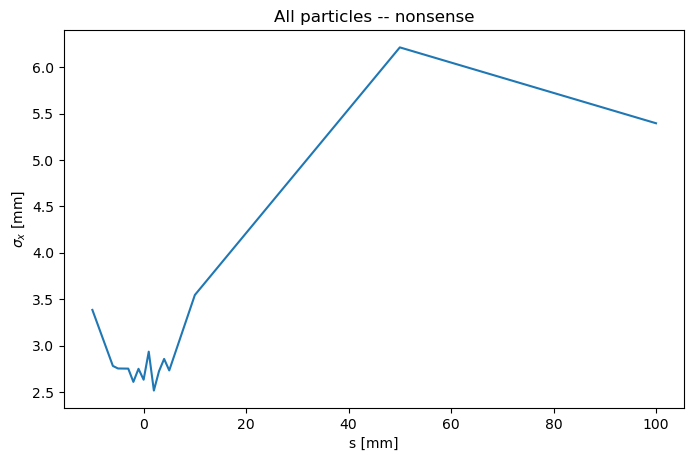

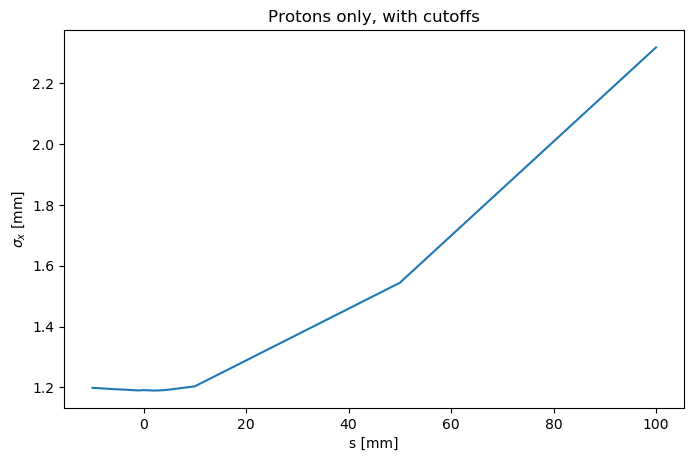

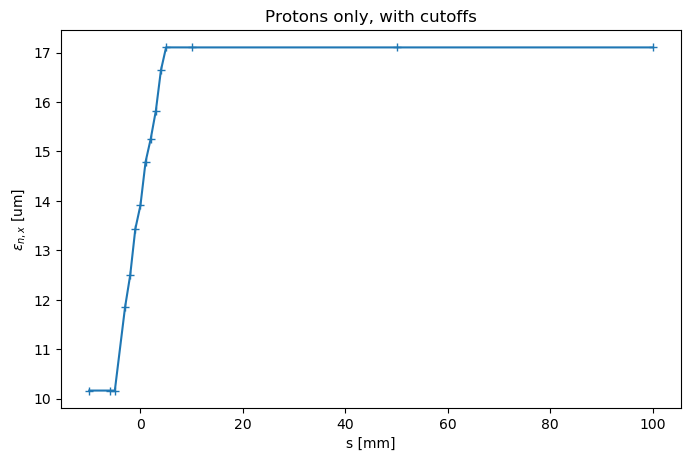

In [8]:

plt.figure()
plt.plot(simSetup_simple1['DIST'],sigmax1)
plt.title("All particles -- nonsense")
plt.xlabel('s [mm]')
plt.ylabel('$\sigma_x$ [mm]')

plt.figure()
plt.plot(simSetup_simple1['DIST'],sigmax2)
plt.title("Protons only, with cutoffs")
plt.xlabel('s [mm]')
plt.ylabel('$\sigma_x$ [mm]')

plt.figure()
plt.plot(simSetup_simple1['DIST'], epsx2, '+-')
plt.title("Protons only, with cutoffs")
plt.xlabel('s [mm]')
plt.ylabel('$\epsilon_{n,x}$ [um]')


plt.show()